# Architecture - 784 - 500 - 300 - 100 - 10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
transformFunc = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x.numpy()[0])
])

In [3]:
trainData = datasets.MNIST(root='./data', train=True, transform=transformFunc, download=True)
testData = datasets.MNIST(root='./data', train=False, transform=transformFunc, download=True)

In [4]:
print(f"type(trainData):  {type(trainData)}")
print(f"len(trainData) :  {len(trainData)}")
print(f"len(testData)  :  {len(testData)}\n")

print(f"type(trainData[0]):  {type(trainData[0])}")
print(f"len(trainData[0]) :  {len(trainData[0])}\n")

print(f"(Image) Type of trainData[0][0]:  {type(trainData[0][0])}")
print(f"(Label) Type of trainData[0][1]:  {type(trainData[0][1])}\n")

print(f"trainData[0][0].shape: {trainData[0][0].shape}")
print(f"Image min/max values: {trainData[0][0].min()}, {trainData[0][0].max()}")

type(trainData):  <class 'torchvision.datasets.mnist.MNIST'>
len(trainData) :  60000
len(testData)  :  10000

type(trainData[0]):  <class 'tuple'>
len(trainData[0]) :  2

(Image) Type of trainData[0][0]:  <class 'numpy.ndarray'>
(Label) Type of trainData[0][1]:  <class 'int'>

trainData[0][0].shape: (28, 28)
Image min/max values: 0.0, 1.0


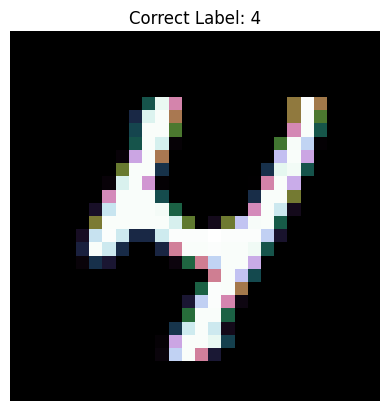

In [5]:
img , label = trainData[4283]
plt.imshow(img, cmap="cubehelix")
plt.title(f"Correct Label: {label}")
plt.axis('off')
plt.show()

In [6]:
def leakyRelu (arr, alpha = 0.01):
    return np.where(arr > 0, arr , alpha * arr)

def leakyReluDerivative (arr, alpha = 0.01):
    return np.where(arr > 0, 1.0, alpha)

def softmax (arr):
    # For a 1D 10-element array
    e = np.exp(arr - np.max(arr))
    return e/e.sum()

def crossEntrophyLoss (label, predicted):
    true = np.zeros(10)
    true[label] = 1
    return -np.sum(true*np.log(predicted))

def xavierLimit (a, b):
    return np.sqrt(6 / (a + b))

def initializeNetwork (a,b,c,d,e):

    l1 = xavierLimit(a,b)
    l2 = xavierLimit(b,c)
    l3 = xavierLimit(c,d)
    l4 = xavierLimit(d,e)

    w1 = np.random.uniform(-l1, l1, size = (a,b))
    w2 = np.random.uniform(-l2, l2, size = (b,c))
    w3 = np.random.uniform(-l3, l3, size = (c,d))
    w4 = np.random.uniform(-l4, l4, size = (d,e))

    b1 = np.zeros(b)
    b2 = np.zeros(c)
    b3 = np.zeros(d)
    b4 = np.zeros(e)

    return [w1, b1, w2, b2, w3, b3, w4, b4]

def initialGradients(w1, b1, w2, b2, w3, b3, w4, b4):
    return [
        np.zeros_like(w1),
        np.zeros_like(b1),
        np.zeros_like(w2),
        np.zeros_like(b2),
        np.zeros_like(w3),
        np.zeros_like(b3),
        np.zeros_like(w4),
        np.zeros_like(b4)
    ]

def makeAllGradientsZero (w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad):
    w1Grad = np.zeros_like(w1Grad)
    b1Grad = np.zeros_like(b1Grad)
    w2Grad = np.zeros_like(w2Grad)
    b2Grad = np.zeros_like(b2Grad)
    w3Grad = np.zeros_like(w3Grad)
    b3Grad = np.zeros_like(b3Grad)
    w4Grad = np.zeros_like(w4Grad)
    b4Grad = np.zeros_like(b4Grad)


def addGradients (w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad, gw1, gb1, gw2, gb2, gw3, gb3, gw4, gb4):
    w1Grad += gw1
    b1Grad += gb1
    w2Grad += gw2
    b2Grad += gb2
    w3Grad += gw3
    b3Grad += gb3
    w4Grad += gw4
    b4Grad += gb4

def divideGradientsByBatchSize (b_size ,w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad):
    w1Grad /= b_size
    b1Grad /= b_size
    w2Grad /= b_size
    b2Grad /= b_size
    w3Grad /= b_size
    b3Grad /= b_size
    w4Grad /= b_size
    b4Grad /= b_size

def forward (image, w1, b1, w2, b2, w3, b3, w4, b4):

    z1 = image.flatten() @ w1 + b1
    a1 = leakyRelu(z1)

    z2 = a1 @ w2 + b2
    a2 = leakyRelu(z2)

    z3 = a2 @ w3 + b3
    a3 = leakyRelu(z3)

    z4 = a3 @ w4 + b4
    a4 = softmax(z4)

    return [z1, a1, z2, a2, z3, a3, z4, a4]

def backward(image, label, w1, b1, w2, b2, w3, b3, w4, b4, z1, a1, z2, a2, z3, a3, z4, a4):

    oneHotEncodedLabel = np.zeros(10)
    oneHotEncodedLabel[label] = 1

    # dl_da4 = -1/a4
    dl_dz4 = a4 - oneHotEncodedLabel
    dl_dw4 = np.outer(a3, dl_dz4)
    dl_db4 = dl_dz4

    dl_da3 = dl_dz4 @ w4.T
    dl_dz3 = dl_da3 * leakyReluDerivative(z3)
    dl_dw3 = np.outer(a2, dl_dz3)
    dl_db3 = dl_dz3

    dl_da2 = dl_dz3 @ w3.T
    dl_dz2 = dl_da2 * leakyReluDerivative(z2)
    dl_dw2 = np.outer(a1, dl_dz2)
    dl_db2 = dl_dz2

    dl_da1 = dl_dz2 @ w2.T
    dl_dz1 = dl_da1 * leakyReluDerivative(z1)
    dl_dw1 = np.outer(image.flatten(), dl_dz1)
    dl_db1 = dl_dz1

    return [dl_dw1, dl_db1, dl_dw2, dl_db2, dl_dw3, dl_db3, dl_dw4, dl_db4]

def updateWeights(learningRate, w1, b1, w2, b2, w3, b3, w4, b4, w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad):
    # parameter = parameter - learningRate * gradient
    w1 -= learningRate * w1Grad
    b1 -= learningRate * b1Grad
    w2 -= learningRate * w2Grad
    b2 -= learningRate * b2Grad
    w3 -= learningRate * w3Grad
    b3 -= learningRate * b3Grad
    w4 -= learningRate * w4Grad
    b4 -= learningRate * b4Grad


def train (data, epoch, batchSize, learningRate, initialWeightsAndBiases):

    trainingAccuracy = []
    trainingLoss = []
    validationAccuracy = []
    validationLoss = []

    w1, b1, w2, b2, w3, b3, w4, b4 = initialWeightsAndBiases

    for epochNumber in range(epoch):
        print(f"\nEpoch: {epochNumber + 1}")
        print("-------")

        w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad = initialGradients(w1, b1, w2, b2, w3, b3, w4, b4)

        # Training Phase
        count = 0
        loss = 0
        correct = 0

        validationSetSize = 10000
        trainingSetSize = len(data) - validationSetSize

        trainingIndices = np.random.permutation(trainingSetSize) + validationSetSize

        for trainingIndex in trainingIndices:

            image = data[trainingIndex][0]
            label = data[trainingIndex][1]

            z1, a1, z2, a2, z3, a3, z4, a4 = forward(image, w1, b1, w2, b2, w3, b3, w4, b4)

            if np.argmax(a4) == label:
                correct += 1

            loss += crossEntrophyLoss(label, a4)

            gw1, gb1, gw2, gb2, gw3, gb3, gw4, gb4 = backward(image, label, w1, b1, w2, b2, w3, b3, w4, b4, z1, a1, z2, a2, z3, a3, z4, a4)

            addGradients(w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad, gw1, gb1, gw2, gb2, gw3, gb3, gw4, gb4)

            count += 1

            if count == batchSize or trainingIndex == trainingIndices[-1]:
                divideGradientsByBatchSize(count, w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad)
                updateWeights(learningRate, w1, b1, w2, b2, w3, b3, w4, b4, w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad)
                makeAllGradientsZero(w1Grad, b1Grad, w2Grad, b2Grad, w3Grad, b3Grad, w4Grad, b4Grad)
                count = 0

        print(f"Training Accuracy   = {100*(correct/trainingSetSize):.2f}%")
        print(f"Training Loss       = {(loss/trainingSetSize):.2f}")
        trainingAccuracy.append(100*(correct/trainingSetSize))
        trainingLoss.append(loss/trainingSetSize)


        # Validation Phase
        correct = 0
        valLoss = 0
        for i in range(validationSetSize):
            image = data[i][0]
            label = data[i][1]
            z1, a1, z2, a2, z3, a3, z4, a4 = forward(image, w1, b1, w2, b2, w3, b3, w4, b4)
            valLoss += crossEntrophyLoss(label, a4)
            if (np.argmax(a4) == label):
                correct += 1

        print(f"Validation Accuracy = {100*correct/validationSetSize:.2f}%")
        print(f"Validation Loss     = {valLoss/validationSetSize:.2f}")
        validationAccuracy.append(100*correct/validationSetSize)
        validationLoss.append(valLoss/validationSetSize)

    return [trainingAccuracy, trainingLoss, validationAccuracy, validationLoss]


def accuracy (data, w1, b1, w2, b2, w3, b3, w4, b4):
    correct = 0
    for i in data:
        image = i[0]
        label = i[1]
        z1, a1, z2, a2, z3, a3, z4, a4 = forward(image, w1, b1, w2, b2, w3, b3, w4, b4)
        if (np.argmax(a4) == label):
            correct += 1
    return correct/len(data)


In [7]:
w1, b1, w2, b2, w3, b3, w4, b4 = initializeNetwork(784, 500, 300, 100, 10)

In [8]:
tA, tL, vA, vL = train(trainData, 30, 20, 0.01, [w1, b1, w2, b2, w3, b3, w4, b4])


Epoch: 1
-------
Training Accuracy   = 87.27%
Training Loss       = 0.47
Validation Accuracy = 92.51%
Validation Loss     = 0.26

Epoch: 2
-------
Training Accuracy   = 93.89%
Training Loss       = 0.21
Validation Accuracy = 94.97%
Validation Loss     = 0.18

Epoch: 3
-------
Training Accuracy   = 95.52%
Training Loss       = 0.15
Validation Accuracy = 95.71%
Validation Loss     = 0.15

Epoch: 4
-------
Training Accuracy   = 96.48%
Training Loss       = 0.12
Validation Accuracy = 96.41%
Validation Loss     = 0.13

Epoch: 5
-------
Training Accuracy   = 97.18%
Training Loss       = 0.10
Validation Accuracy = 96.44%
Validation Loss     = 0.12

Epoch: 6
-------
Training Accuracy   = 97.68%
Training Loss       = 0.08
Validation Accuracy = 97.12%
Validation Loss     = 0.10

Epoch: 7
-------
Training Accuracy   = 98.06%
Training Loss       = 0.07
Validation Accuracy = 97.17%
Validation Loss     = 0.09

Epoch: 8
-------
Training Accuracy   = 98.34%
Training Loss       = 0.06
Validation Accur

In [9]:
print(f"Accuracy = {100 * accuracy(testData, w1, b1, w2, b2, w3, b3, w4, b4):.2f}%")

Accuracy = 98.09%


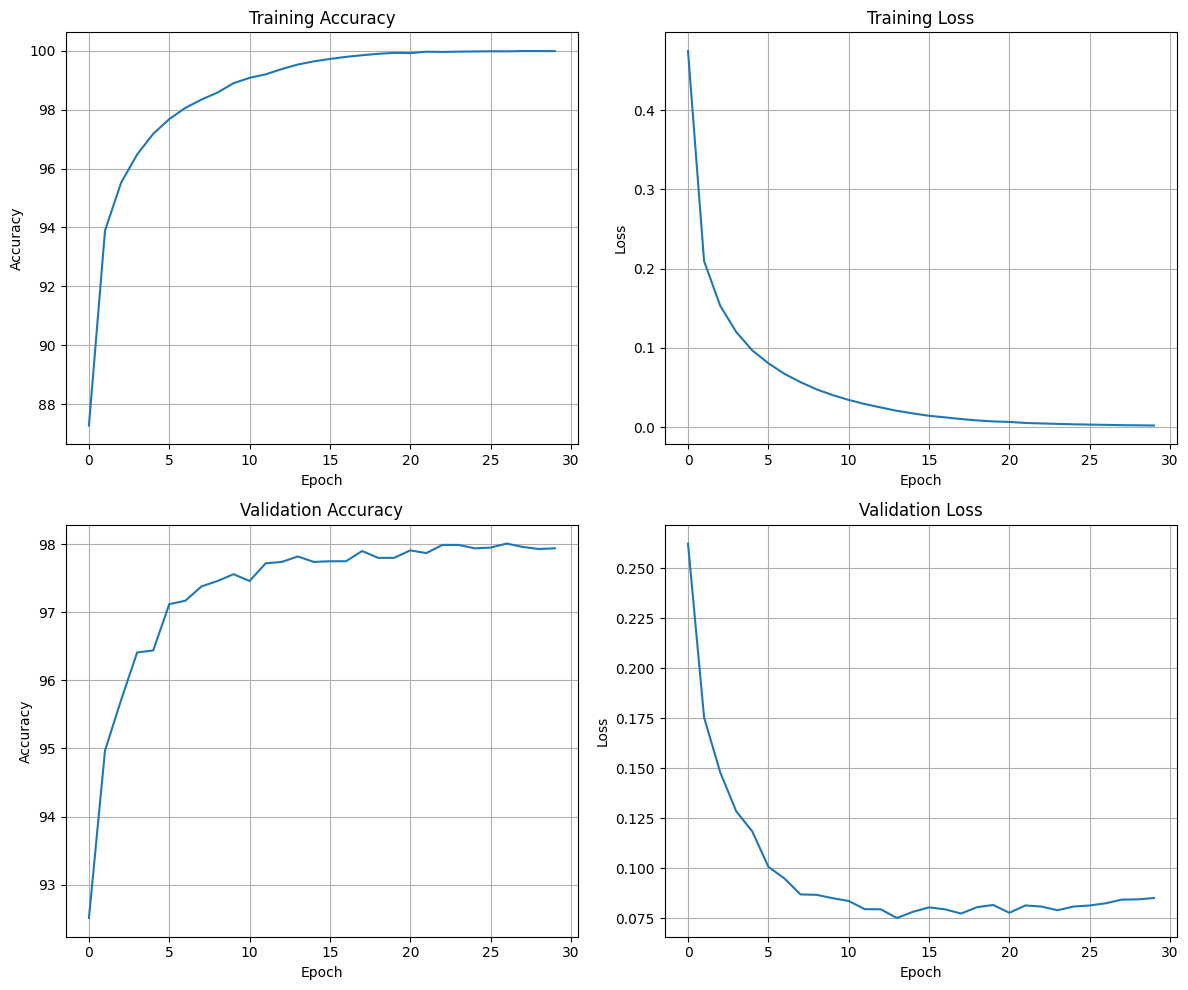

In [10]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Training Accuracy
axes[0, 0].plot(tA)
axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].grid(True)

# Plot Training Loss
axes[0, 1].plot(tL)
axes[0, 1].set_title('Training Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

# Plot Validation Accuracy
axes[1, 0].plot(vA)
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True)

# Plot Validation Loss
axes[1, 1].plot(vL)
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()